# Convert atlas tiffs from 3D tif to 2D tif series for ims conversion

In [ ]:
from pystripe.core import *
image = imread_tif_raw_png(Path(r"X:\atlas_3d\fmost_vtk\Nissl_10um.tif"))
out_put = Path(r"X:\atlas_3d\fmost_vtk\Nissl_10um.2D.tif.series")
out_put.mkdir(exist_ok=True)
for idx, img in enumerate(image):
    imwrite( out_put/ f"img_{idx:04n}.tif", img,  compression=("Adobe_Deflate", 1))

---

## Explanation: Masking a 3D Image Based on a Custom-Oriented Plane

This guide explains how to mask one half of a 3D image using a custom-oriented plane defined by three points.

### Step 1: Compute the Plane Equation

Given three points in 3D:

- $p_1 = (x_1, y_1, z_1)$
- $p_2 = (x_2, y_2, z_2)$
- $p_3 = (x_3, y_3, z_3)$

**1. Form Two Vectors on the Plane:**

$$
\mathbf{v}_1 = p_2 - p_1 \quad \text{and} \quad \mathbf{v}_2 = p_3 - p_1
$$

**2. Compute the Normal Vector of the Plane:**

Calculate the normal vector $\mathbf{n} = (A, B, C)$ using the cross product:

$$
\mathbf{n} = \mathbf{v}_1 \times \mathbf{v}_2
$$

**3. Express the Plane Equation:**

Using the point-normal form, the plane equation is:

$$
A(x - x_1) + B(y - y_1) + C(z - z_1) = 0
$$

Rearrange it to the standard form:

$$
Ax + By + Cz + D = 0 \quad \text{where} \quad D = -\mathbf{n} \cdot p_1
$$

### Step 2: Create a Coordinate Grid for the 3D Image

- **Representation:**  
  The 3D image is assumed to be a NumPy array with dimensions (e.g., `[X, Y, Z]`).

- **Grid Generation:**  
  Use a function like `np.indices` to generate a grid that matches the image dimensions. This creates coordinate matrices representing the $x$, $y$, and $z$ voxel positions.

### Step 3: Evaluate the Plane Function at Each Voxel

For each voxel, compute the function:

$$
f(x, y, z) = Ax + By + Cz + D
$$

The sign of $f(x, y, z)$ indicates which side of the plane the voxel belongs to:

- **$f(x, y, z) > 0$:** Voxel is on one side of the plane.
- **$f(x, y, z) < 0$:** Voxel is on the opposite side.

### Step 4: Create and Apply the Mask

- **Determine the Desired Side:**  
  Decide whether you want to mask the side where $f(x, y, z)$ is positive or negative.

- **Create the Boolean Mask:**  
  For example, if you want to mask the positive side, define:

  ```python
  mask = f > 0
  ```

  Alternatively, for the negative side, use:

  ```python
  mask = f < 0
  ```

- **Apply the Mask:**  
  Use the mask to modify the 3D image (e.g., setting masked voxels to zero).

---

### Note:

If the equations still do not render properly in your Jupyter Notebook, consider the following troubleshooting steps:

- **Trust the Notebook:**  
  Ensure that the notebook is trusted. Untrusted notebooks may sometimes not render LaTeX properly.

- **MathJax Settings:**  
  Verify that MathJax is enabled in your Jupyter configurations.

- **Formatting:**  
  Use `$...$` for inline expressions and `$$...$$` for block (display) equations, as shown above.

This explanation outlines the reasoning behind masking a 3D image using a plane defined by three points and should now display properly within a Jupyter Notebook cell. Enjoy integrating it into your workflow!

942
angle between vectors on left  yz plane: 14.04
angle between vectors on right yz plane: 14.04
angle between vectors on left  xy plane: 34.09
angle between vectors on right xy plane: 34.09


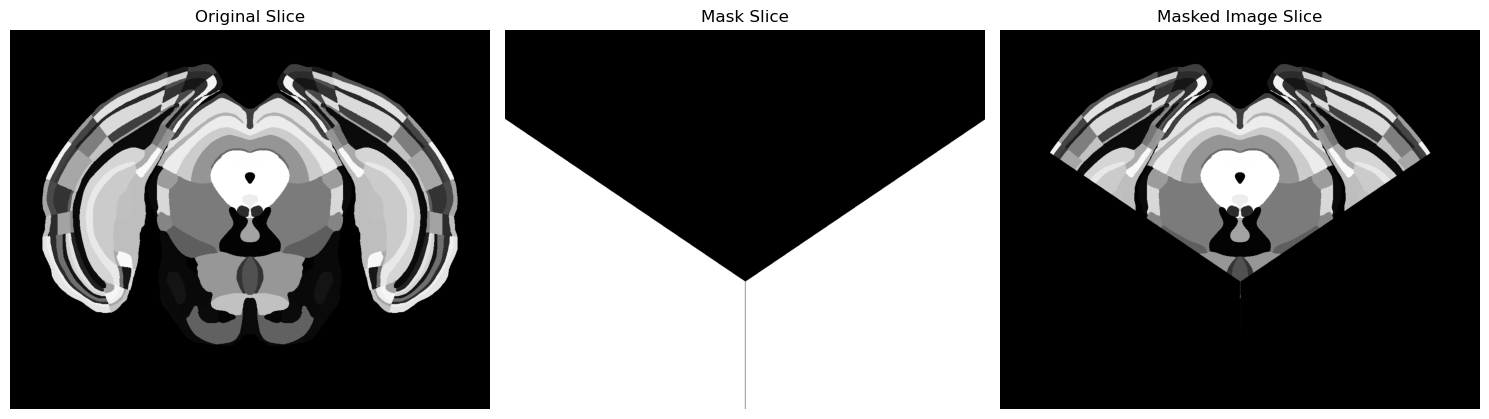

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from pystripe.core import *

def angle_between_vectors(a: np.array, b: np.array, degrees=True):
    """
    Calculate the angle between two vectors.
    
    Parameters:
    a (array-like): First vector.
    b (array-like): Second vector.
    degrees (bool): If True, returns angle in degrees. Otherwise, in radians.
    
    Returns:
    float: Angle between vectors.
    """
   
    # input vectors are in zyx order, but a and b should be in xyz order
    a = a[[2, 1, 0]]
    b = b[[2, 1, 0]]
    
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    cos_theta = dot_product / (norm_a * norm_b)
    
    # Clip value to avoid numerical issues outside the range [-1, 1]
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    angle = np.arccos(cos_theta)
    
    if degrees:
        angle = np.degrees(angle)
        
    return angle

def create_plane_mask(image, p1, p2, p3, midline_x=None, side='positive', voxel_size=10):
    """
    Create a mask for a 3D image based on:
    - A plane defined by three points (x, y, z)
    - An optional vertical midline plane at x = midline_x
    
    Parameters
    ----------
    image : np.ndarray
        3D array representing the image volume. Must have shape (z, y, x).
    p1, p2, p3 : tuple/list/np.ndarray
        Three (x, y, z) points defining the first plane.
    midline_x : float or None
        x-coordinate for second vertical plane (optional).
    side : str
        Which region to select: 'positive', 'negative', 'positive_left', etc.
    voxel_size : float
        Scaling of voxel dimensions (default 1).

    Returns
    -------
    mask : np.ndarray
        Boolean mask of the same shape as image.
    """
    
    # Convert points to NumPy arrays and apply voxel size scaling
    p1 /= voxel_size
    p2 /= voxel_size
    p3 /= voxel_size
    
    if midline_x is not None:
        midline_x = midline_x / voxel_size
    
    # Calculate two vectors lying on the plane
    v1 = p2 - p1
    v2 = p3 - p1
    
    # Compute normal vector
    normal = np.cross(v1, v2)
    
    # Compute D in the plane equation Ax + By + Cz + D = 0
    D = -np.dot(normal, p1)
    
    # Create coordinate grids
    # WARNING: image.shape = (z, y, x) --> so np.indices gives Z, Y, X
    Z, Y, X = np.indices(image.shape)
    
    # Now X, Y, Z represent real physical (x, y, z) coordinates
    # (after voxel_size adjustment they are fine)
    
    # Evaluate the first plane function at each voxel
    F_plane = normal[0] * Z + normal[1] * Y + normal[2] * X + D
    
    # Create mask for first plane
    if 'positive' in side:
        mask_plane = F_plane > 0
    elif 'negative' in side:
        mask_plane = F_plane < 0
    else:
        raise ValueError("`side` must contain 'positive' or 'negative'.")
    
    # Create mask for midline if needed
    if midline_x is not None:
        F_midline = X - midline_x
        if 'right' in side:
            mask_midline = F_midline > 0
        elif 'left' in side:
            mask_midline = F_midline < 0
        else:
            mask_midline = np.ones_like(mask_plane, dtype=bool)
    else:
        mask_midline = np.ones_like(mask_plane, dtype=bool)
    
    # Combine masks
    final_mask = mask_plane & mask_midline
    
    return final_mask

def visualize_slices(image_slice, mask_slice, masked_image_slice):
    """
    Visualizes the original image slice, the mask slice, and the masked image slice side-by-side.
    
    Parameters:
      image_slice (np.ndarray): A 2D slice from the original image.
      mask_slice (np.ndarray): The corresponding 2D boolean mask slice.
      masked_image_slice (np.ndarray): A 2D slice from the masked image.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image slice.
    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title("Original Slice")
    axes[0].axis('off')
    
    # Mask slice.
    axes[1].imshow(mask_slice, cmap='gray')
    axes[1].set_title("Mask Slice")
    axes[1].axis('off')
    
    # Masked image slice.
    axes[2].imshow(masked_image_slice, cmap='gray')
    axes[2].set_title("Masked Image Slice")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    image = imread_tif_raw_png(Path(r"X:\atlas_3d\fmost_vtk\9.3.label.tif"))
    # image = imread_tif_raw_png(Path(r"X:\atlas_3d\fmost_vtk\Nissl_10_symmetric.tif"))

    # Define three points that lie within the image bounds.
    voxel_size = 10 # um
    y=3700
    z=9740
    p1_l = np.array((9100, 3860, 8940), dtype=np.float64) # Left rostral in xy plane (z,y,x) um unit
    p2_l = np.array((9100, 3640, 9265), dtype=np.float64) # orthogonal to the axial axis of SUB in xy plane (9100, 3650, 9510)
    p3_l = np.array((z, y, 8940), dtype=np.float64) # (9765, 3945, 8925)
    p1_r = np.array((9100, 3860, 2470), dtype=np.float64) # right rostral 
    p2_r = np.array((9100, 3640, 2145), dtype=np.float64) # orthogonal to the axial axis of SUB in xy plane (1880, 3650, 9100)
    p3_r = np.array((z, y, 2470), dtype=np.float64) # 
    
    slice_index = int((p1_l[0] + p3_l[0]) / voxel_size / 2)
    
    print(f"angle between vectors on left  yz plane: {angle_between_vectors(p3_l - p1_l, np.array((1, 0, 0), dtype=np.float64)):.2f}")
    print(f"angle between vectors on right yz plane: {angle_between_vectors(p3_r - p1_r, np.array((1, 0, 0), dtype=np.float64)):.2f}")

    print(f"angle between vectors on left  xy plane: {angle_between_vectors(p2_l - p1_l, np.array((0, 0, 1), dtype=np.float64)):.2f}")
    print(f"angle between vectors on right xy plane: {angle_between_vectors(p2_r - p1_r, np.array((0, 0, -1), dtype=np.float64)):.2f}")

    # Create a mask for one side of the plane (e.g. the positive side).
    mask = create_plane_mask(image, p1_l, p2_l, p3_l, image.shape[2]*voxel_size//2, side=['positive', 'right'], voxel_size=voxel_size) | create_plane_mask(image, p1_r, p2_r, p3_r, image.shape[2]*voxel_size//2, side=['negative', 'left'], voxel_size=voxel_size)

    # Create a masked version of the image.
    masked_image = image.copy()
    masked_image[mask] = 0  # Setting voxels on the masked side to 0.
    visualize_slices(image[slice_index, :, :], mask[slice_index, :, :], masked_image[slice_index, :, :])

# the following table will be used to merge parts of SUBv to SUBd or ProSUB based on the mask generated above

| Acronym     | Gray | Name                                      | Parent  | Structure                                         |
|-------------|------|-------------------------------------------|---------|--------------------------------------------------|
| ProSUB      | 3185 | prosubiculum                             | SUB     | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB       |
| SUBdd       | 3199 | dorsal subiculum, dorsal part            | SUB     | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB       |
| SUBvv       | 3116 | ventral subiculum, ventral tip           | SUB     | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB       |
| SUBdm       | 458  | Subiculum, dorsal part, molecular layer  | SUBdd   | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBdd |
| SUBvm       | 812  | Subiculum, ventral part, molecular layer | SUBvv   | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv |
| SUBdsr      | 298  | Subiculum, dorsal part, stratum radiatum | SUBdd   | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBdd |
| SUBvsr      | 954  | Subiculum, ventral part, stratum radiatum| SUBvv   | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv |
| SUBdsp      | 319  | Subiculum, dorsal part, pyramidal layer  | SUBdd   | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBdd |
| SUBvsp      | 3044 | Subiculum, ventral part, pyramidal layer | SUBvv   | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv |
| SUBdsp1     | 195  | SUBdsp1                                  | SUBdsp  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBdd\|SUBdsp |
| SUBvsp1     | 928  | SUBvsp1                                  | SUBvsp  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv\|SUBvsp |
| ProSUBsp3   | 344  | ProSUBsp3                                | ProSUB  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|ProSUB |
| SUBvsp2     | 507  | SUBvsp2                                  | SUBvsp  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv\|SUBvsp |
| ProSUBsp4   | 1023 | ProSUBsp4                                | ProSUB  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|ProSUB |
| SUBvsp3     | 300  | SUBvsp3                                  | SUBvsp  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv\|SUBvsp |
| SUBdsp4     | 293  | SUBdsp4                                  | SUBdsp  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBdd\|SUBdsp |
| SUBvsp4     | 850  | SUBvsp4                                  | SUBvsp  | root\|grey\|CH\|CTX\|CTXpl\|HPF\|RHP\|SUB\|SUBvv\|SUBvsp |

In [109]:
from supplements.croping import imwrite_lzw

labels = imread_tif_raw_png(Path(r"X:\atlas_3d\fmost_vtk\9.3.label.tif"))
labels[~mask & (labels == 812 )] = 458
labels[~mask & (labels == 954 )] = 298
labels[~mask & (labels == 3044)] = 319
labels[~mask & (labels == 928 )] = 195
labels[~mask & (labels == 507 )] = 344
labels[~mask & (labels == 300 )] = 1023
labels[~mask & (labels == 850 )] = 293
imwrite_lzw(Path(r"X:\atlas_3d\fmost_vtk\9.3.label_SUBd_mod_lzw.tif"), labels, convert_16bit_to_8bit=False)